In [1]:
!pip install torch==1.13.1+cu117 torchvision==0.14.1+cu117 torchaudio==0.13.1 --extra-index-url https://download.pytorch.org/whl/cu117 > /dev/null
!pip install deepfloyd-if==1.0.1rc0 > /dev/null
!pip install xformers==0.0.16 > /dev/null
!pip install git+https://github.com/openai/CLIP.git --no-deps > /dev/null

  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-cjjp0a8q


In [2]:
!pip list | grep deepfloyd
!pip list | grep xformers
!pip list | grep torch
!nvidia-smi

deepfloyd-if                           1.0.1rc0
xformers                               0.0.16
pytorch-ignite                         0.4.11
pytorch-lightning                      1.9.4
torch                                  1.13.1+cu117
torchaudio                             0.13.1+cu117
torchinfo                              1.7.2
torchmetrics                           0.11.4
torchtext                              0.14.0
torchvision                            0.14.1+cu117
Thu Mar 27 14:51:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                             

In [3]:
import os
os.environ['FORCE_MEM_EFFICIENT_ATTN'] = "1"
import sys
import random

import torch
import numpy as np
import torch.nn.functional as F
import torchvision.transforms as T

from deepfloyd_if.modules import IFStageI, IFStageII, StableStageIII

FORCE_MEM_EFFICIENT_ATTN= 1 @UNET:QKVATTENTION


100%|███████████████████████████████████████| 890M/890M [00:10<00:00, 91.4MiB/s]


In [ ]:
hf_token = ''

device = 'cuda:0'
if_I = IFStageI('IF-I-XL-v1.0', device=device, hf_token=hf_token)

/opt/conda/lib/python3.7/site-packages/huggingface_hub/file_download.py:1081: FutureWarning: The `force_filename` parameter is deprecated as a new caching system, which keeps the filenames as they are on the Hub, is now in place.
  FutureWarning,


In [5]:
%%time

if_II = IFStageII('IF-II-L-v1.0', device='cuda:1', hf_token=hf_token)

CPU times: user 4.81 s, sys: 5.16 s, total: 9.98 s
Wall time: 15.2 s


In [6]:
%%time

if_III = StableStageIII('stable-diffusion-x4-upscaler', device='cuda:1')

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

Keyword arguments {'token': None} are not expected by StableDiffusionUpscalePipeline and will be ignored.


CPU times: user 8.63 s, sys: 10.5 s, total: 19.1 s
Wall time: 20.1 s


## Get prepared T5 Embs for ready prompts:

In [7]:
prompts, t5_embs = [], []
for prompt_idx in [14,43]:
    prompt = open(f'/kaggle/input/t5-prompts-if/{str(prompt_idx).zfill(4)}.txt').read().strip()
    t5_numpy = np.load(f'/kaggle/input/t5-prompts-if/{str(prompt_idx).zfill(4)}.npy')
    t5_embs.append(torch.from_numpy(t5_numpy).unsqueeze(0))
    prompts.append(prompt)

t5_embs = torch.cat(t5_embs).to(device)
t5_embs.shape

torch.Size([2, 77, 4096])

# Stage-I: 64px

  0%|          | 0/50 [00:00<?, ?it/s]

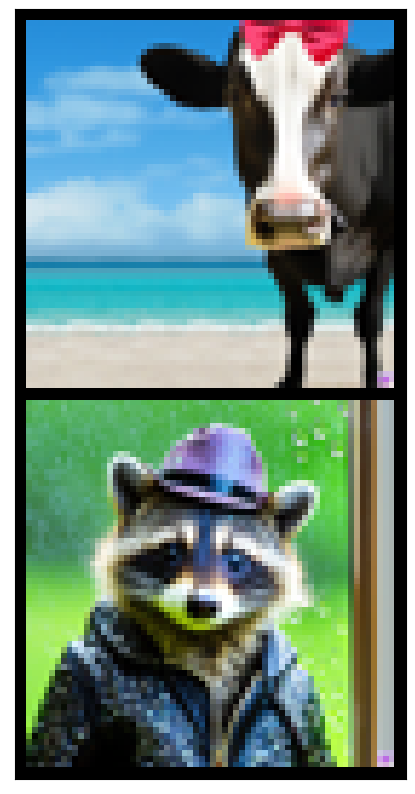

In [8]:
seed = 42

stageI_generations, _meta = if_I.embeddings_to_image(
    t5_embs, seed=seed, batch_repeat=1,
    dynamic_thresholding_p=0.95,
    dynamic_thresholding_c=1.5,
    guidance_scale=7.0,
    sample_loop='ddpm',
    sample_timestep_respacing='smart50',
    image_size=64,
    aspect_ratio="1:1",
    progress=True,
)
pil_images_I = if_I.to_images(stageI_generations)
if_I.show(pil_images_I)

# Stage-II: 64px --> 256 px

In [9]:
stageII_generations, _meta = if_II.embeddings_to_image(
    stageI_generations,
    t5_embs, seed=seed, batch_repeat=1,
    dynamic_thresholding_p=0.95,
    dynamic_thresholding_c=1.0,
    aug_level=0.25,
    guidance_scale=4.0,
    image_scale=4.0,
    sample_loop='ddpm',
    sample_timestep_respacing='50',
    progress=True,
)
pil_images_II = if_II.to_images(stageII_generations)
if_II.show(pil_images_II)

  0%|          | 0/50 [00:00<?, ?it/s]

# Stage-III: 256px --> 1024px

In [10]:
stageIII_generations = []
for idx in range(len(stageII_generations)):
    if_III_kwargs = {}
    if_III_kwargs['prompt'] = prompts[idx:idx+1]
    if_III_kwargs['low_res'] = stageII_generations[idx:idx+1]
    if_III_kwargs['seed'] = seed
    if_III_kwargs['t5_embs'] = t5_embs[idx:idx+1]
    _stageIII_generations, _meta = if_III.embeddings_to_image(**if_III_kwargs)
    stageIII_generations.append(_stageIII_generations)

stageIII_generations = torch.cat(stageIII_generations, 0)
pil_images_III = if_III.to_images(stageIII_generations)

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

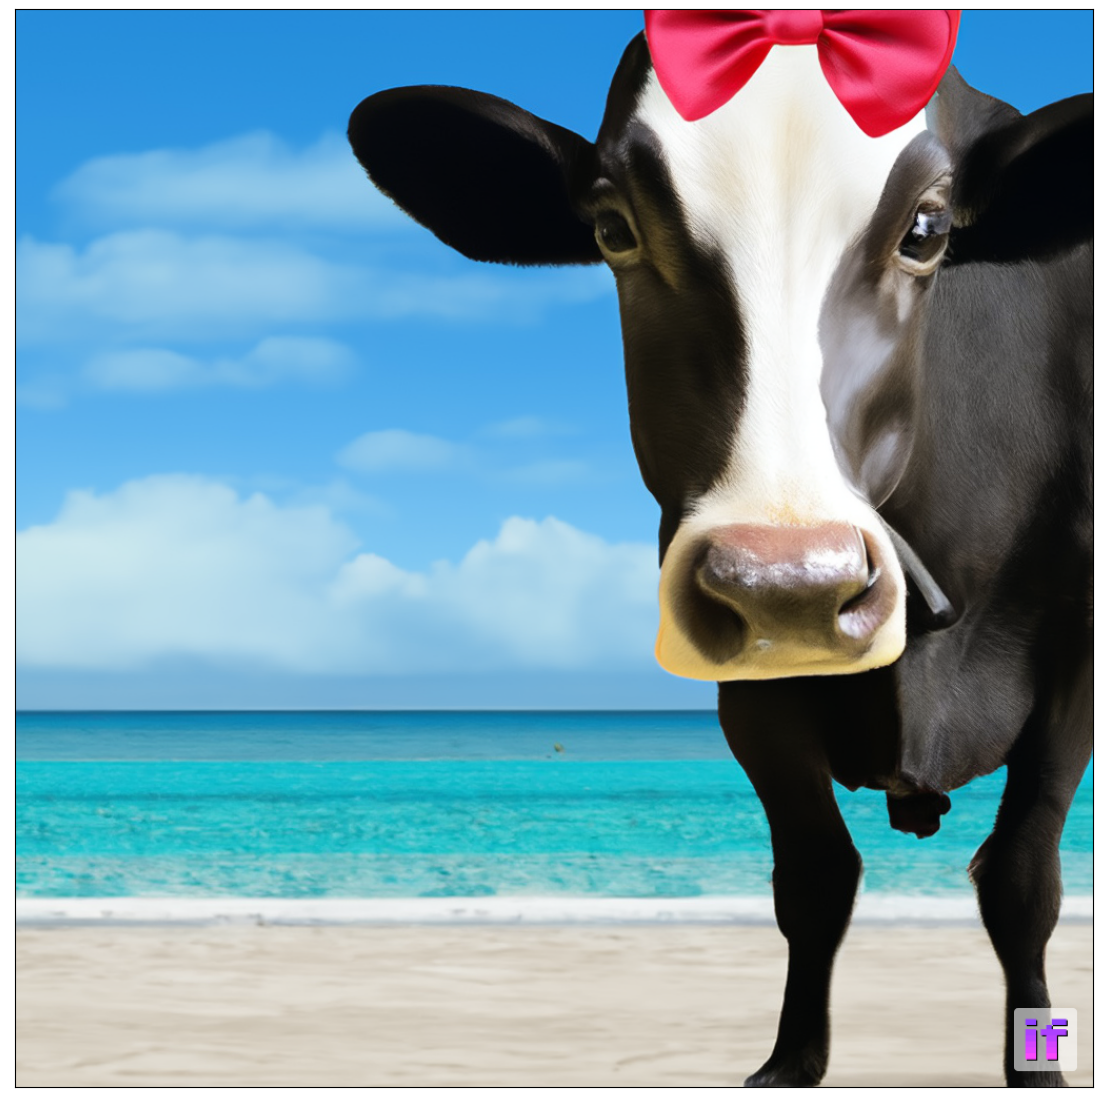

a photo of a person with the head of a cow, wearing a tuxedo and black bowtie. beach wallpaper in the background. 





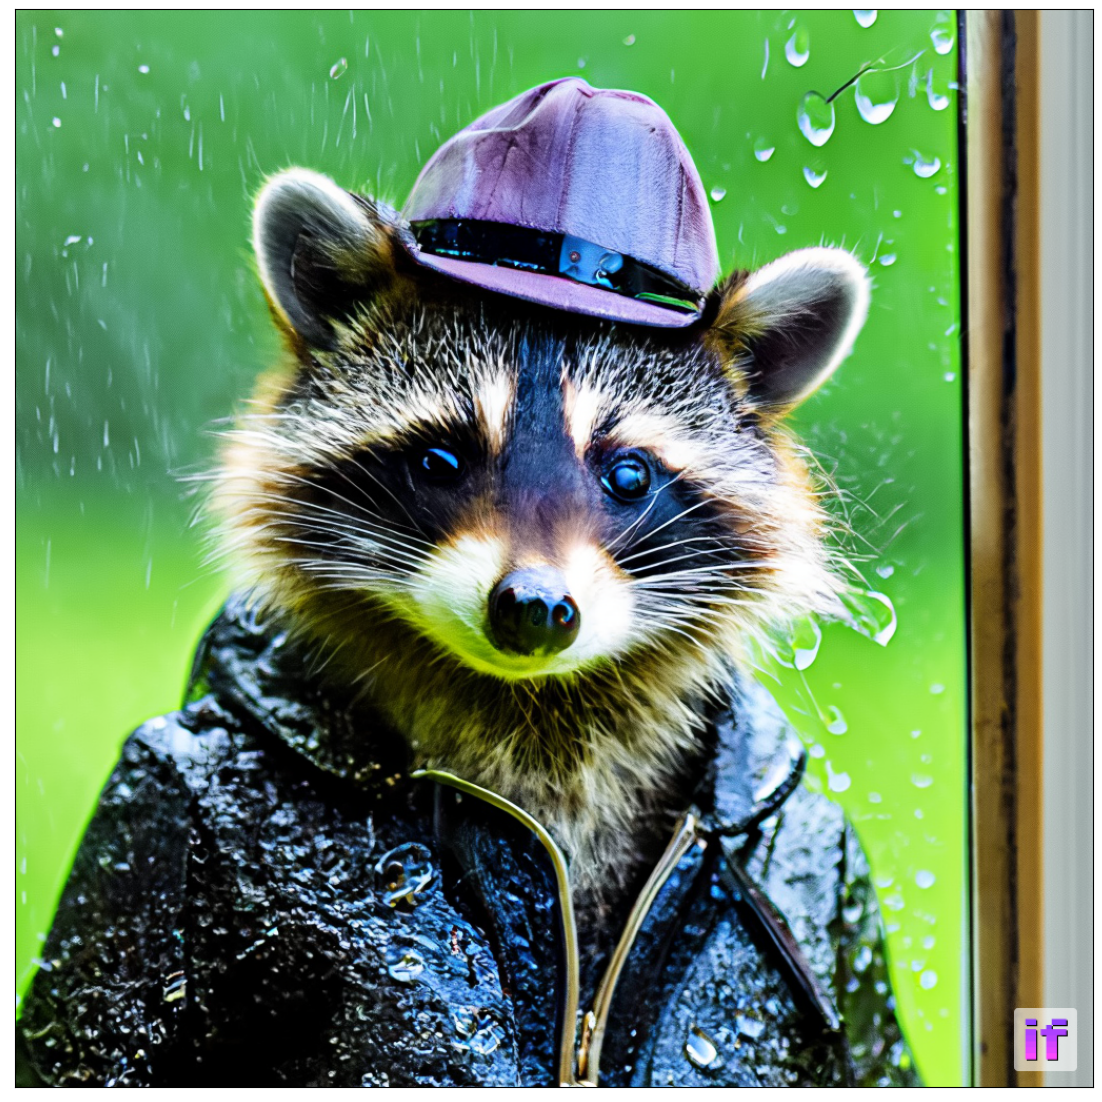

a raccoon wearing cowboy hat and black leather jacket is behind the backyard window. rain droplets on the window. 





In [11]:
for pil_img, prompt in zip(pil_images_III, prompts):
    if_I.show([pil_img],size=14)
    print(prompt, '\n'*3)